In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
# add the path of the virtual environmentsite-packages to colab system path
sys.path.append("/content/drive/MyDrive/virtual_env/lib/python3.10/site-packages")

In [ ]:
!chmod 755 -R /content/drive/MyDrive/virtual_env/bin

In [ ]:
!source /content/drive/MyDrive/virtual_env/bin/activate; pip install adjustText

In [ ]:
from adjustText import adjust_text
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
import os
import seaborn as sns
import sys
from glob import iglob

In [ ]:
# verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')


scanpy==1.9.8 anndata==0.10.5.post1 umap==0.5.5 numpy==1.25.2 scipy==1.11.4 pandas==1.5.3 scikit-learn==1.2.2 statsmodels==0.14.1 igraph==0.10.8 pynndescent==0.5.11


In [ ]:
# the directory with the `.h5` file
# use gene symbols for the variable names (variables-axis index)
output_data_dir="/content/drive/MyDrive/LeoDai/Private_Data/Clustering/Chimp"
output_fig_dir="/content/drive/MyDrive/LeoDai/Private_Data/Clustering/Chimp/Figs"
input_dir="/content/drive/MyDrive/LeoDai/Private_Data/Preprocessing/chimp"
sc.settings.figdir = output_fig_dir

In [ ]:
#read in inh cells
sub_adata = sc.read(os.path.join(input_dir,"inh_filt_norm.h5ad"))
print(sub_adata)

In [ ]:
tmp = sc.read(os.path.join(input_dir,"inh_subclass.h5ad"))
print(tmp)

In [ ]:
sub_smplist = sub_adata.obs_names.tolist()

In [ ]:
raw_adata = sc.read(os.path.join(input_dir,"chimp_all_raw_filt.h5ad"))
print(raw_adata)

/content/drive/MyDrive/virtual_env/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 86856 × 20189
    obs: 'doublet_score', 'predicted_doublet', 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'n_genes', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'


In [ ]:
adata = raw_adata[raw_adata.obs_names.isin(sub_smplist),:]
print(adata)

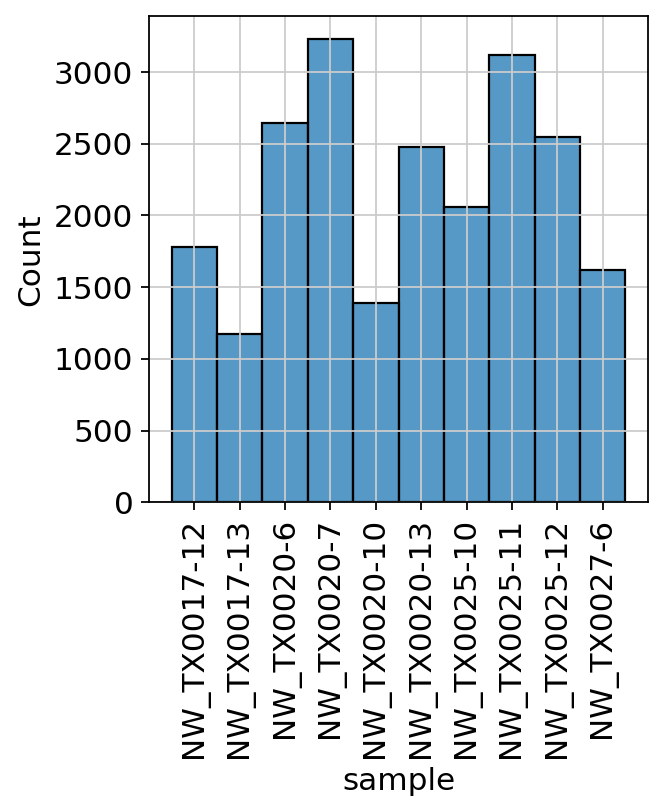

In [ ]:
#print(sub_adata.obs['sample'].value_counts())
#fig, axs = plt.subplots(1,1,figsize=(5,10))
plot = sns.histplot(adata.obs["sample"], kde=False)
plt.setp(plot.get_xticklabels(), rotation=90)
plt.savefig(os.path.join(output_fig_dir,"inh_sample_dist.png"),bbox_inches="tight")

/content/drive/MyDrive/virtual_env/lib/python3.10/site-packages/scanpy/plotting/_utils.py:432: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/content/drive/MyDrive/virtual_env/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/content/drive/MyDrive/virtual_env/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


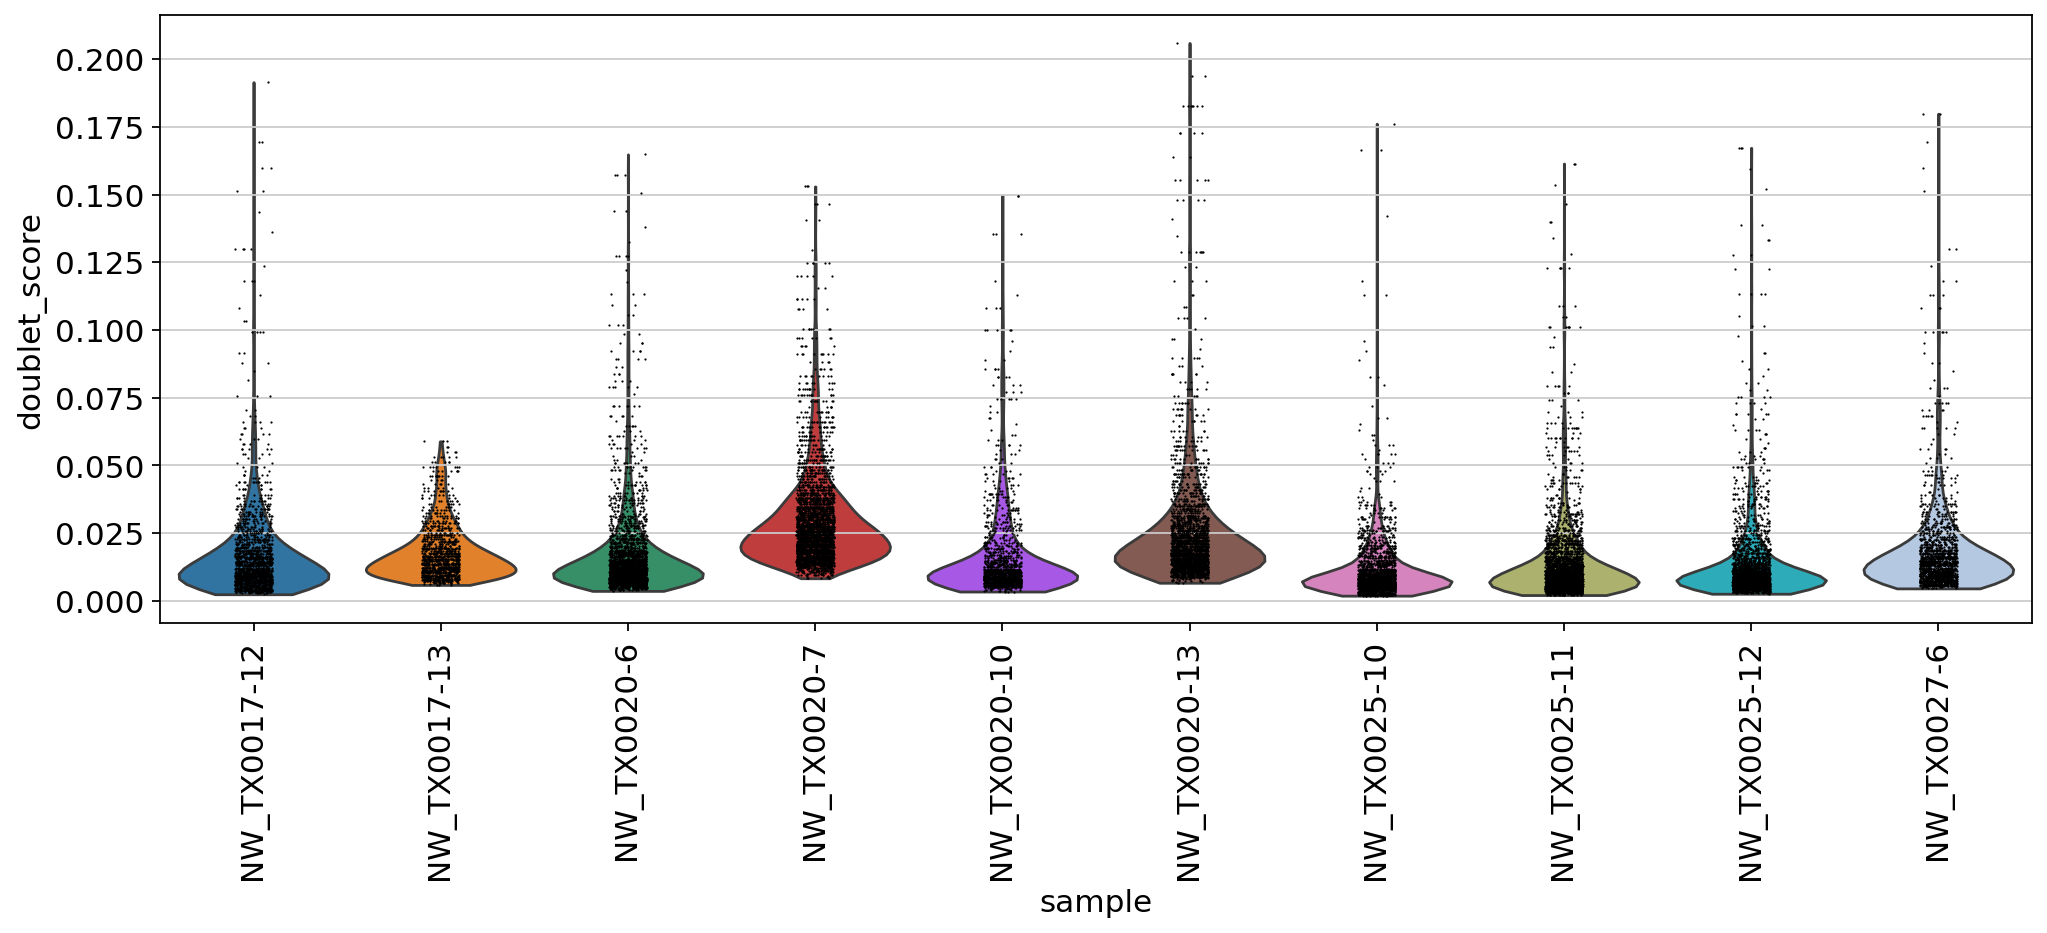

In [ ]:
fig, axs = plt.subplots(1,1,figsize=(15,5))
plot = sc.pl.violin(adata, keys="doublet_score", groupby="sample", ax=axs, show=False)
plt.setp(plot.get_xticklabels(), rotation=90)
plt.savefig(os.path.join(output_fig_dir,"inh_doublet_score.png"),bbox_inches="tight")

In [ ]:
# calculate percent ribosomal genes
ribo_genes = adata.var_names.str.startswith(("RPS","RPL"))
print(sum(ribo_genes))
adata.var['ribo'] = adata.var_names.str.startswith(("RPS","RPL"))
## the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
#adata.obs['percent_ribo'] = np.sum(
#    adata[:, ribo_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1

False    19146
Name: mt, dtype: int64


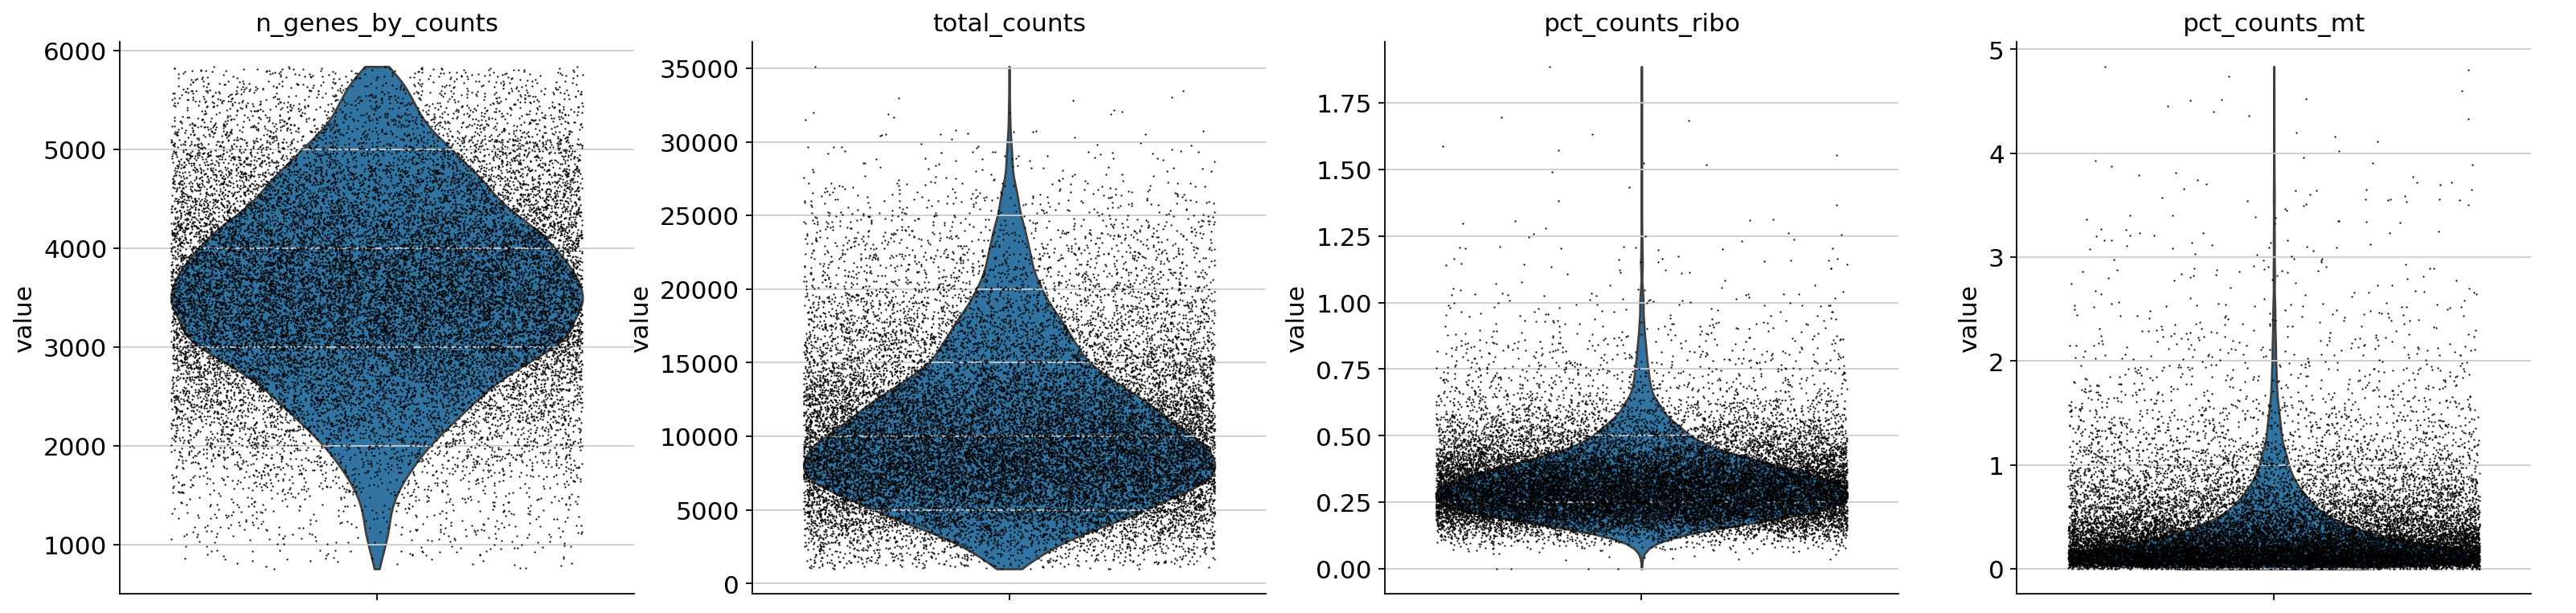

In [ ]:
# annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt','ribo'], percent_top=None, log1p=False, inplace=True)
print(adata.var['mt'].value_counts())
adata.obs['pct_counts_mt'] = raw_adata[raw_adata.obs_names.isin(sub_smplist),:].obs['pct_counts_mt']
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_ribo','pct_counts_mt'],jitter=0.4, multi_panel=True, show=False)
plt.savefig(os.path.join(output_fig_dir,"inh_mt_ribo_qc.png"))
#plt.show()

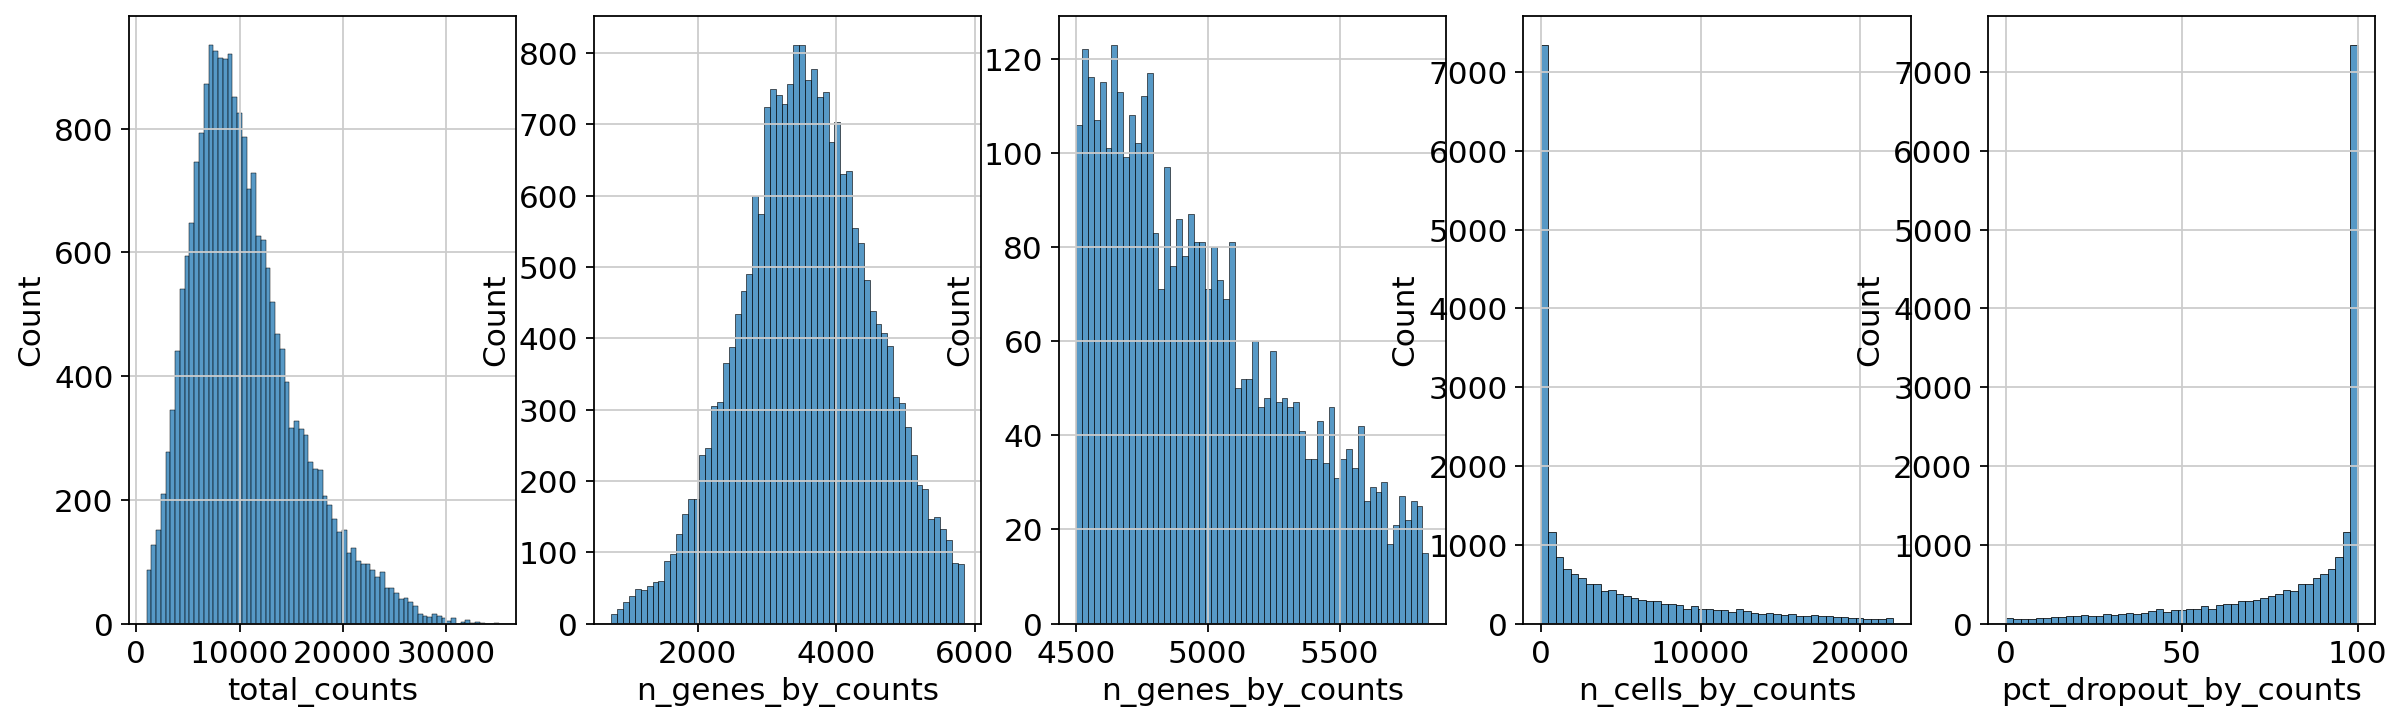

In [ ]:
fig, axs = plt.subplots(1, 5, figsize=(18, 5))
sns.histplot(adata.obs["total_counts"], kde=False, ax=axs[0])
sns.histplot(adata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[1])
sns.histplot(adata.obs["n_genes_by_counts"][sub_adata.obs["n_genes_by_counts"] > 4500], kde=False, bins=60, ax=axs[2])
sns.histplot(adata.var["n_cells_by_counts"], kde=False, ax=axs[3])
sns.histplot(adata.var["pct_dropout_by_counts"], kde=False, ax=axs[4])
plt.savefig(os.path.join(output_fig_dir,"inh_counts_dist.png"))


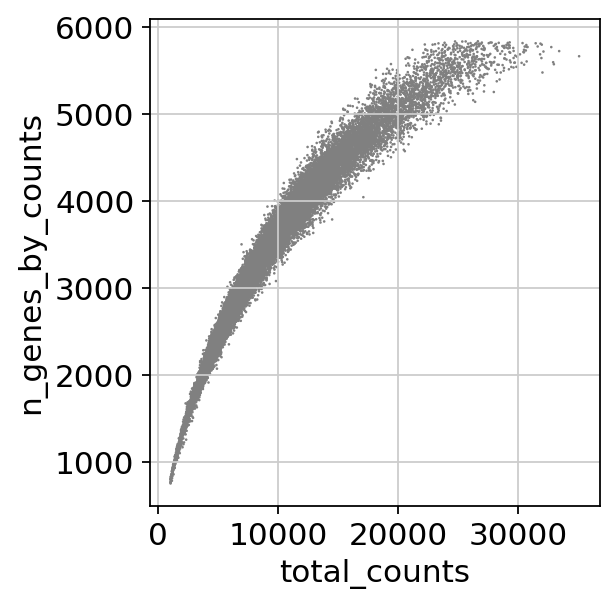

In [ ]:
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts',show=False)
plt.savefig(os.path.join(output_fig_dir,"inh_genes_by_counts.png"))
#Can color plot based on any variable from obs

/content/drive/MyDrive/virtual_env/lib/python3.10/site-packages/scanpy/preprocessing/_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics


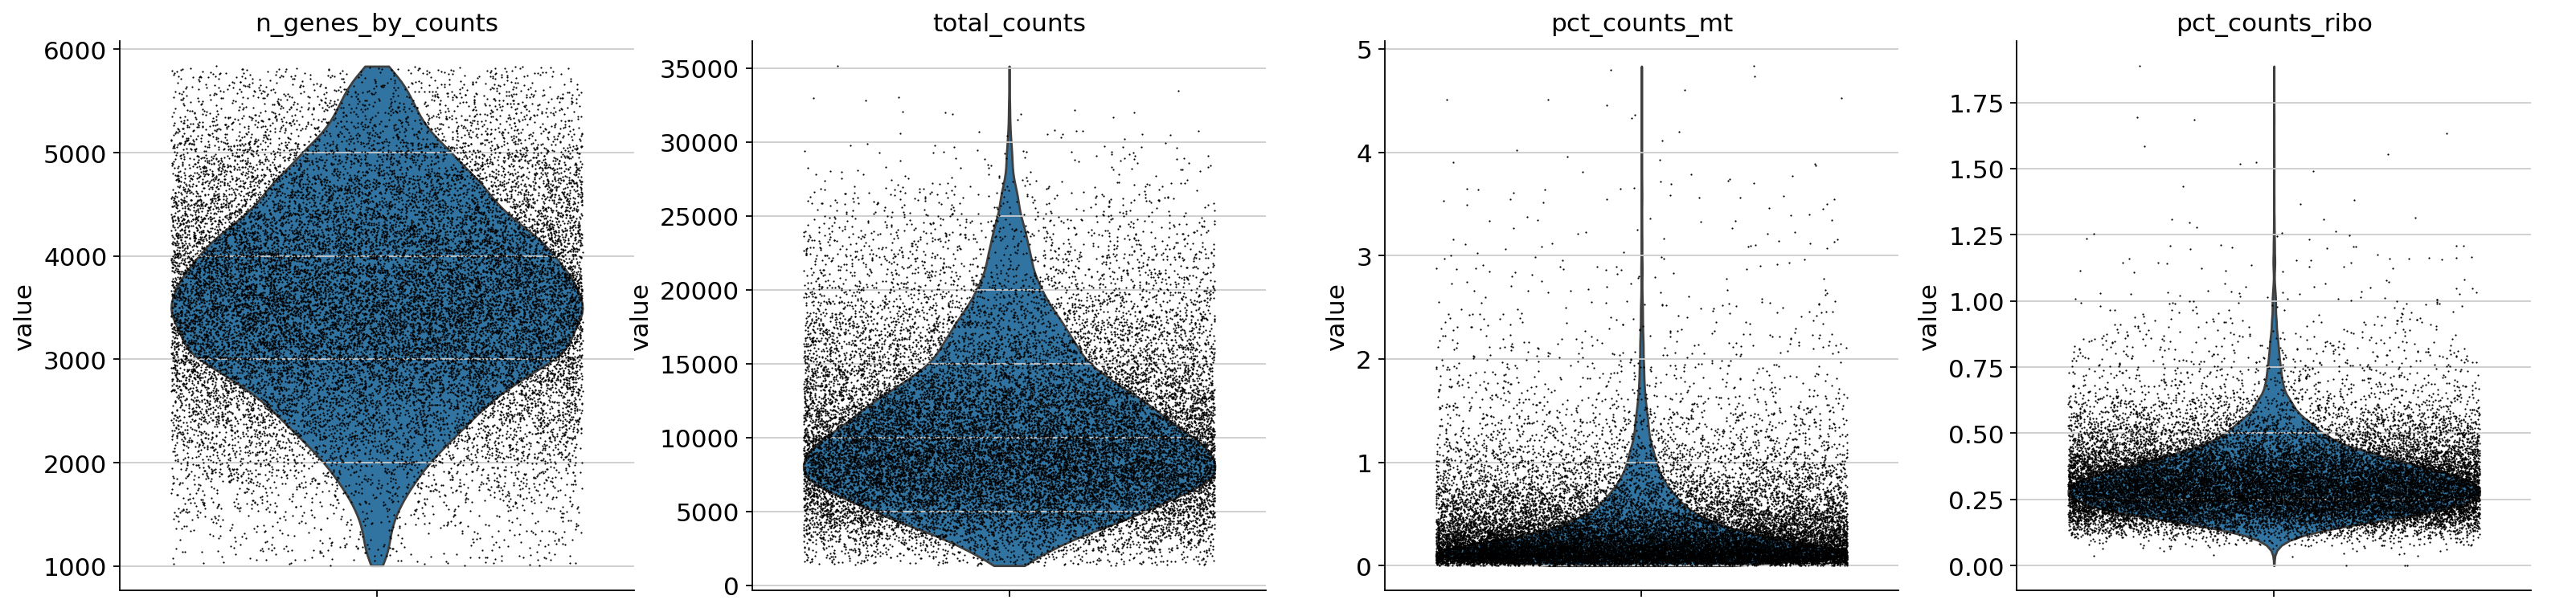

In [ ]:
#filter cells by number of genes per cell
adata = adata[adata.obs.n_genes_by_counts > 1000, :]
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt','ribo'], percent_top=None, log1p=False, inplace=True)
#mitocondrial genes were removed in the processed adata, add it back from the raw_adata the percent counts mt to the adata of the specific cell class adata
adata.obs['pct_counts_mt'] = raw_adata[raw_adata.obs_names.isin(sub_smplist),:].obs['pct_counts_mt']
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_ribo'],jitter=0.4, multi_panel=True,show=False)
plt.savefig(os.path.join(output_fig_dir,"inh_filtering_genes_qc.png"))
#save a copy of adata after every major change

In [ ]:
#sc.pp.filter_cells(adata, max_counts=40000)
sc.pp.filter_genes(adata, min_cells=3)
#sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)
#sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts'],jitter=0.4, multi_panel=True,save=False)
#plt.savefig(os.path.join(output_fig_dir,"filt_qc.png"))
print(adata)

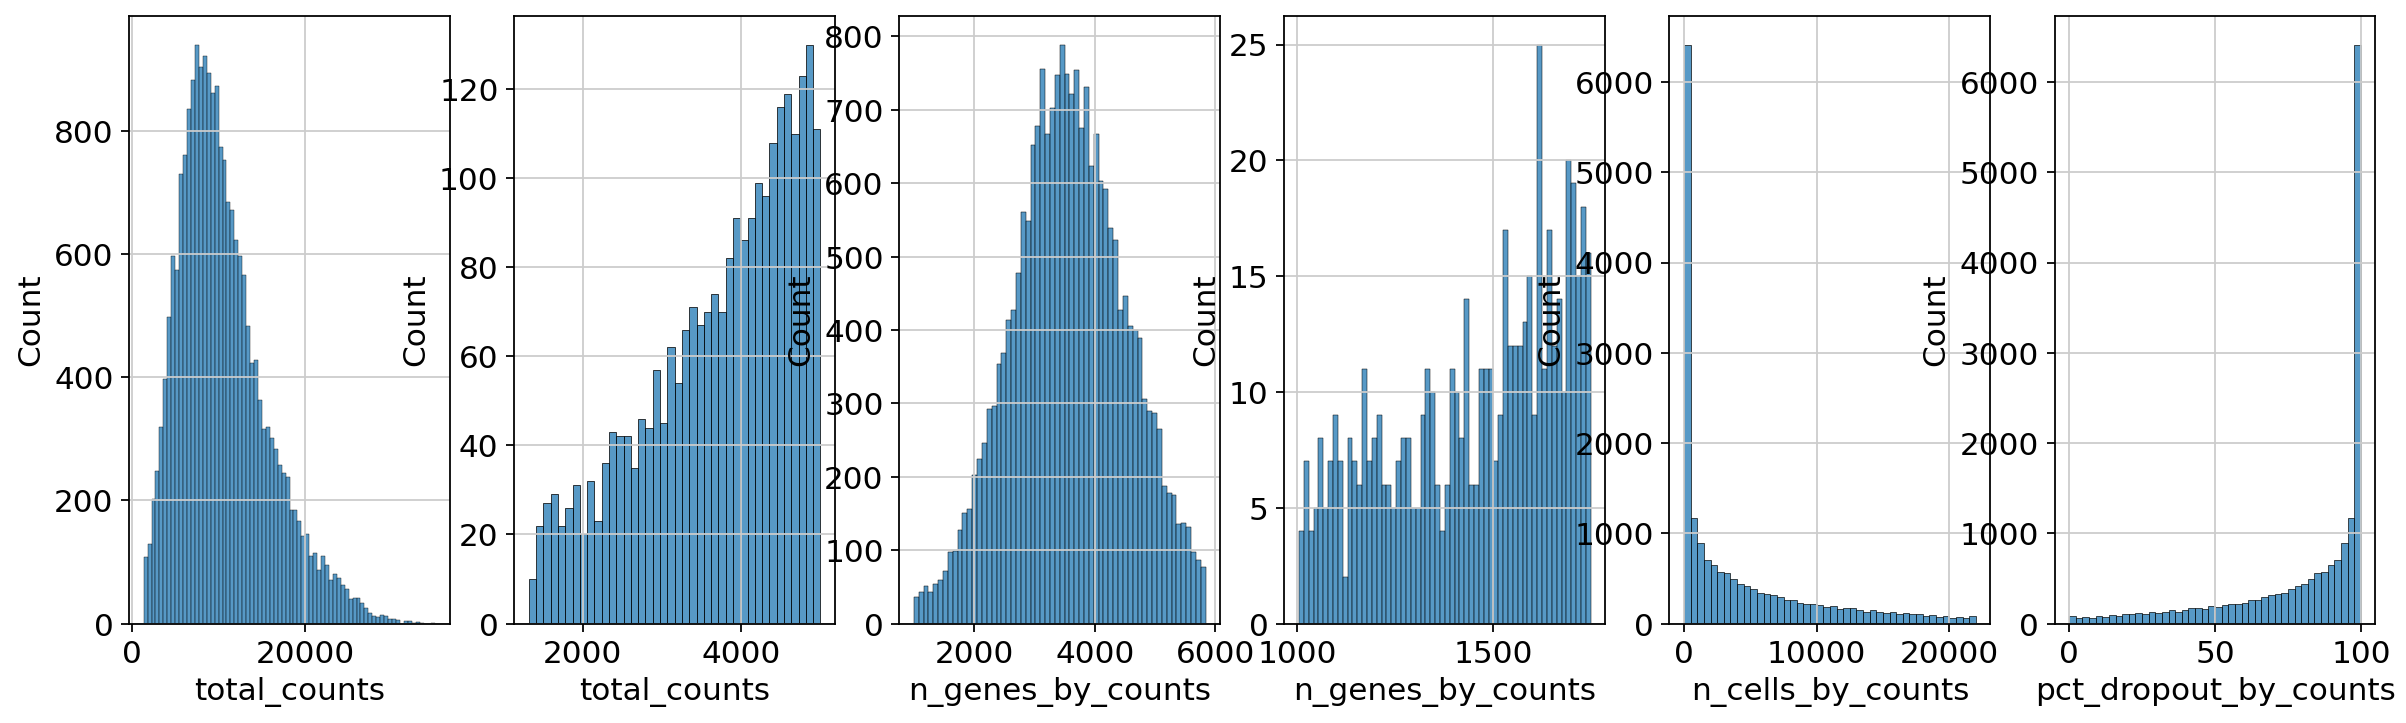

In [ ]:
fig, axs = plt.subplots(1, 6, figsize=(18, 5))
sns.histplot(adata.obs["total_counts"], kde=False, ax=axs[0])
sns.histplot(adata.obs["total_counts"][adata.obs["total_counts"] < 5000], kde=False, bins=40, ax=axs[1])
sns.histplot(adata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
sns.histplot(adata.obs["n_genes_by_counts"][adata.obs["n_genes_by_counts"] < 1750], kde=False, bins=60, ax=axs[3])
sns.histplot(adata.var["n_cells_by_counts"], kde=False, ax=axs[4])
sns.histplot(adata.var["pct_dropout_by_counts"], kde=False, ax=axs[5])
plt.savefig(os.path.join(output_fig_dir,"after_filtering_inh_counts_dist.png"))

In [ ]:
#normalization
#normalize to 10000 reads, log transformed,
sc.pp.normalize_total(adata, target_sum=1e4)

sc.pp.log1p(adata)

extracting highly variable genes
    finished (0:00:11)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
1996


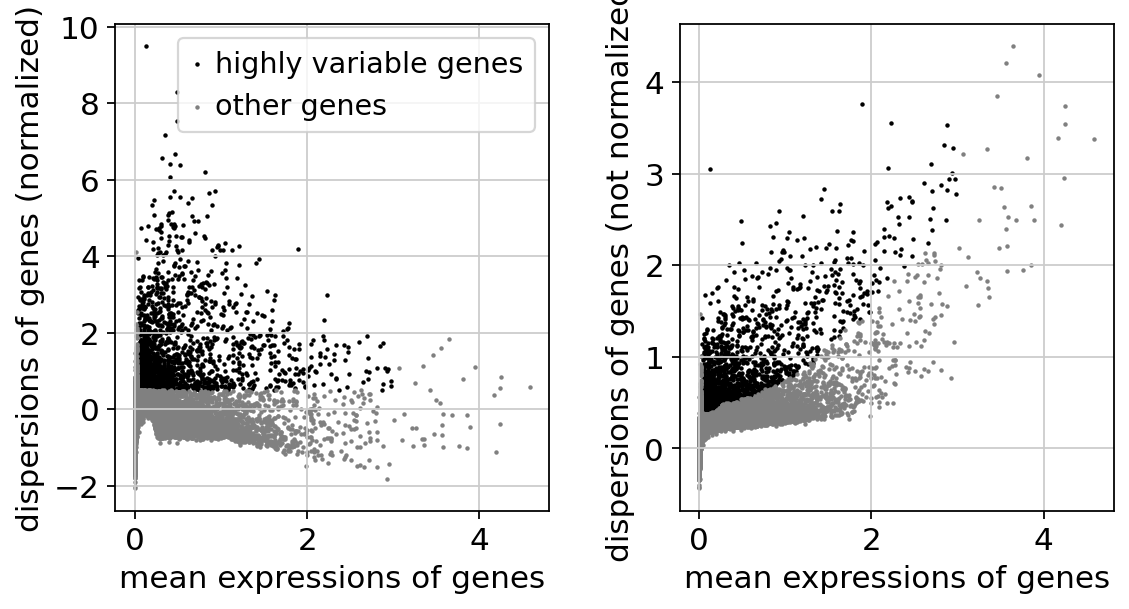

In [ ]:
#Identify highly-variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.025, max_mean=3, min_disp=0.5, flavor="seurat", batch_key='sample')
sc.pl.highly_variable_genes(adata,show=False)
plt.savefig(os.path.join(output_fig_dir,"inh_highly_variable_genes.png"))
print(len(adata.var_names[adata.var.highly_variable]))

In [ ]:
#save normalized adata
adata.raw = adata

In [ ]:
hvg_df = pd.DataFrame()
hvg_df['gene'] = adata.var_names
hvg_df['hvg'] = adata.var.highly_variable.tolist()
hvg_df.to_csv(os.path.join(output_data_dir,"inh_hvg.txt"),index=False,sep="\t")

In [ ]:
#ribosomal genes in highly variable genes
hvg_gene = adata.var_names[adata.var.highly_variable]

In [ ]:
#The result of the previous highly-variable-genes detection is stored as an annotation in .var.highly_variable and auto-detected by PCA and hence, sc.pp.neighbors and subsequent manifold/graph tools. In that case, the step actually do the filtering below is unnecessary, too.

#Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed, and ribosomal gene expressed. Scale the data to unit variance.
adata = adata[:, adata.var.highly_variable]

print(adata)
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt','pct_counts_ribo'])
#Scale each gene to unit variance. Clip values exceeding standard deviation 10.
sc.pp.scale(adata, max_value=10)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:04)


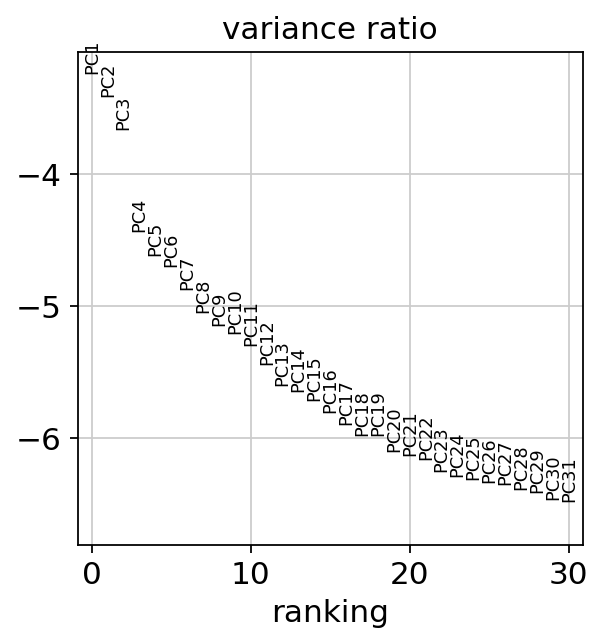

In [ ]:
#Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.

sc.tl.pca(adata, svd_solver='arpack')

sc.pl.pca_variance_ratio(adata, log=True,show=False)
plt.savefig(os.path.join(output_fig_dir,"inh_pca_var_ratio.png"))

In [ ]:
#batch correction
sc.external.pp.harmony_integrate(adata, 'sample')
#replcae PCA by the batch corrected data
adata.obsm['X_pca'] = adata.obsm['X_pca_harmony']
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=30)
sc.tl.umap(adata)


In [ ]:
sc.tl.leiden(adata, resolution=4)
print(adata.obs.leiden.value_counts())

/content/drive/MyDrive/virtual_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/content/drive/MyDrive/virtual_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


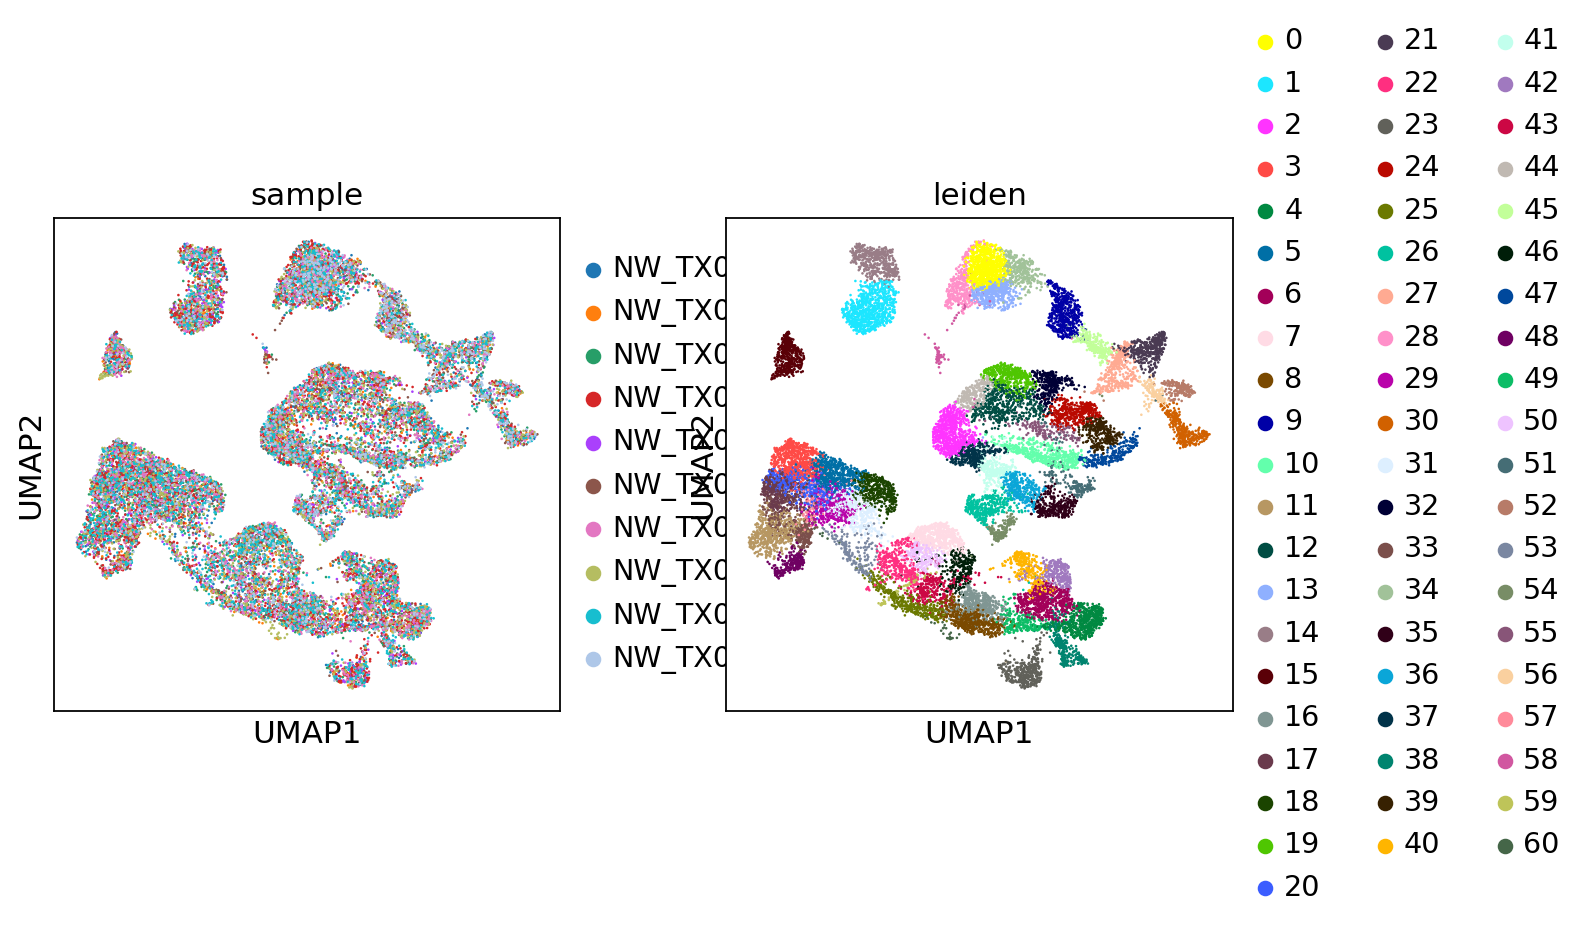

In [ ]:
sc.pl.umap(adata, color=["sample","leiden"], cmap="tab20",show=False)
plt.savefig(os.path.join(output_fig_dir,"inh_Harmony_umap_by_sample.png"))

In [ ]:
#Get the most variable genes that define each cluster
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False,show=False)
plt.savefig(os.path.join(output_fig_dir,"inh_level2_rank_genes_groups.png"))

In [ ]:
adata.write_h5ad(os.path.join(output_data_dir,"inh_level2_clustered.h5ad"),compression='gzip')

print(adata)

In [ ]:
#calculate paga & plot
sc.tl.paga(adata)
sc.pl.paga(adata, plot=False,show =False,use_raw=True)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(adata, init_pos='paga')
#sc.pl.umap(adata, color=["sample","leiden"], cmap="tab20",show=False
#plt.savefig(os.path.join(output_dir,"paga_leiden_cluster.png"))

/content/drive/MyDrive/virtual_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/content/drive/MyDrive/virtual_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


[<Axes: title={'center': 'sample'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'leiden'}, xlabel='UMAP1', ylabel='UMAP2'>]

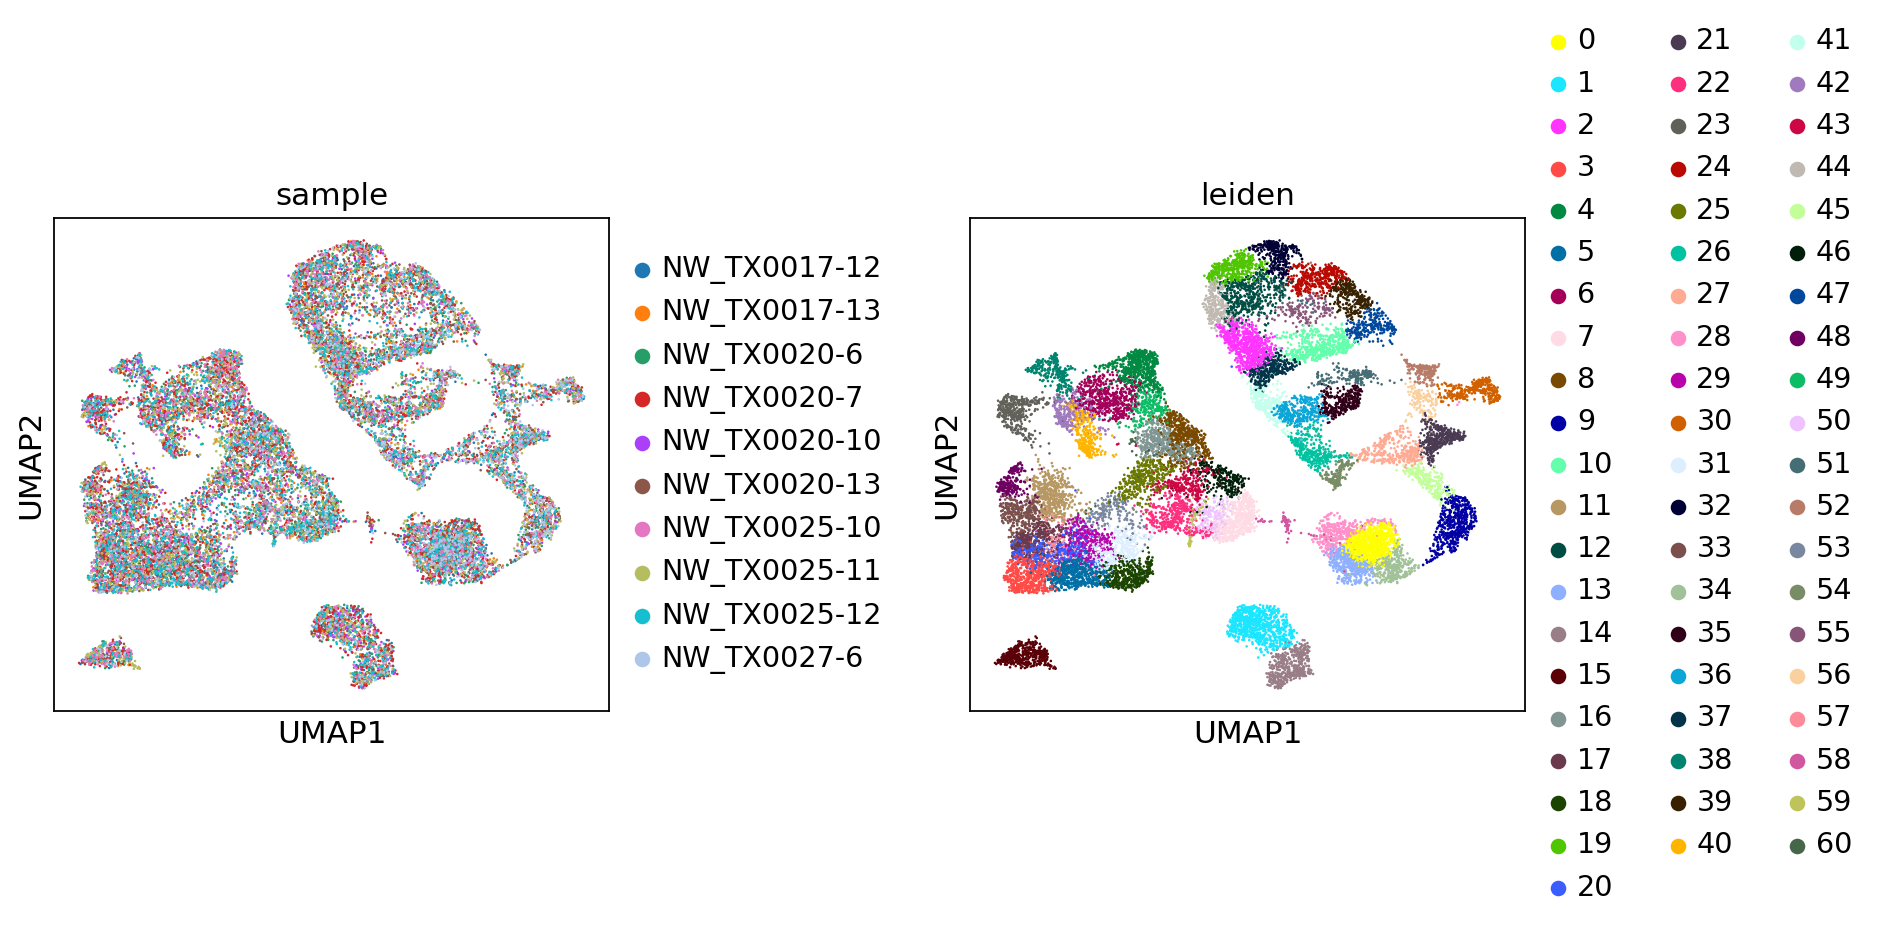

In [ ]:
sc.pl.umap(adata, color=["sample","leiden"], cmap="tab20",show=False, wspace = 0.5)
plt.savefig(os.path.join(output_fig_dir,"inh_level2_clustered_umap.png"))

In [ ]:
Lamp5 = ["EYA4","LAMP5"] #,"Pde11a"]
Meis2 = ["MEIS2"]
Pvalb = ["PVALB","ENSPTRG00000020961","SLC26A4"] # ENSG00000236107  = LOC101929680
Sncg = ["SDK2","ATP2B4"] # CNR1 = CANN6 = ENSG00000118432
Sst_chod = ["NPY"]
Sst =["NXPH1","SOX6","SST"]
Vip =["VIP","LAMA3","IQGAP2"]


marker_genes = Lamp5 + Meis2 + Pvalb + Sncg + Sst + Vip + Sst_chod



In [ ]:
marker_genes= ['ALDH1L1', 'GFAP', 'PDGFRA','VCAN','MBP', 'TYROBP','OPALIN', 'MOBP', 'CLDN11','COL20A1', 'IL1R1','SLC1A3','INPP5D','COLEC12','MCAM','CXCL12','SRGN']


/content/drive/MyDrive/virtual_env/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


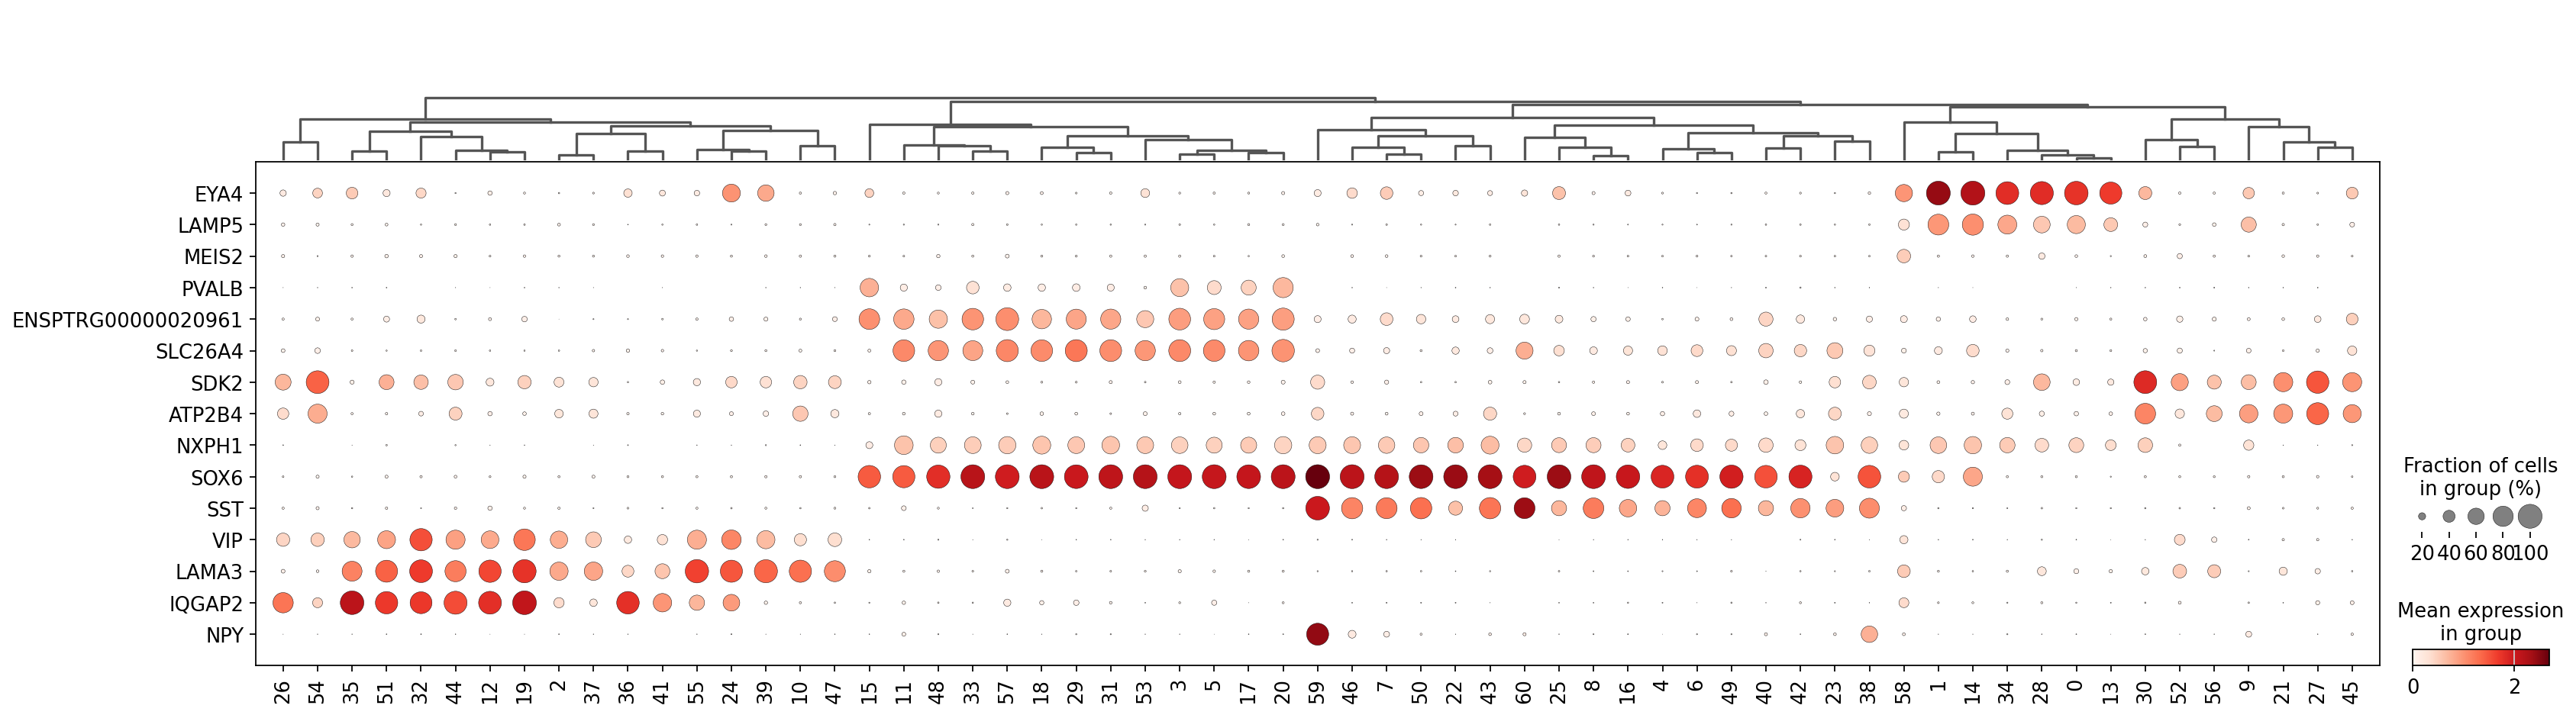

<Figure size 320x320 with 0 Axes>

In [ ]:
sc.pl.dotplot(adata, var_names=marker_genes, groupby="leiden", dendrogram=True, swap_axes=True,show=False)
plt.savefig(os.path.join(output_fig_dir,"inh_level2_dotplot.png"))

In [ ]:
pvalb_1 = ["15"]; sst_1 = ["7"]; sst_2 = ["4"]; sst_3 = ["6"]; sst_4 = ["8"]; sst_5 = ["16"];
pvalb_2 = ["11"]; sst_6 = ["25","60"];sst_7 = ["22"]; sst_8 = ["43"] ; sst_9 = ["46"]; sst_10 = ["40"];
pvalb_3 = ["48"]; sst_11 = ["42"]; sst_12 = ["49"]; sst_13 = ["50"]; sst_14 = ["23"]; sst_15 = ["38"]; sst_chod = ["59"];

pvalb_4 = ["33"]; sncg_1 = ["9"]; sncg_2 = ["21"]; sncg_3 = ["27"]; sncg_4 = ["45"]; sncg_5 = ["30"]; sncg_6 = ["52"]; sncg_7 = ["56"]
pvalb_5 = ["57"]; meis2_lamp5 = ["58"]; sncg_vip_pval_1 = ["10"]; sncg_vip_pval_2 = ["47"]; sncg_vip_3 = ["36"]; sncg_vip_4 = ["41"];
pvalb_6 = ["18"]; sncg_vip_1 = ["26"]; sncg_vip_2 = ["54"];

pvalb_7 = ["29"] ; vip_2 = ["12"]; vip_7 =["44"]; vip_8 = ["19"]; vip_1 = ["2"]; vip_9 = ["37"];
pvalb_8 = ["31"];  vip_4 = ["24"]; vip_10 = ["39"]; vip_11 = ["55"];  vip_3 = ["35"]; vip_6 = ["51"]; vip_5 = ["32"];

pvalb_9 = ["53"]; lamp5_1 = ["1"]; lamp5_2 = ["14"]; lamp5_3 = ["0"]; lamp5_4 = ["13"]; lamp5_5 = ["34"]; lamp5_6 = ["28"];
pvalb_10 = ["3"];
pvalb_11 = ["5"]
pvalb_12 = ["17"]
pvalb_13 = ["20"]


In [ ]:
flist = pvalb_1 + pvalb_2 + pvalb_3 + pvalb_4 + pvalb_5 + pvalb_6 + pvalb_7 + pvalb_8 + pvalb_9 + pvalb_10 + pvalb_11 + pvalb_12 + pvalb_13
flist = flist + sst_1 + sst_2 + sst_3 + sst_4 + sst_5 + sst_6 + sst_7 + sst_8 + sst_9 + sst_10 + sst_11 + sst_12 + sst_13 + sst_chod + sst_14 + sst_15
flist = flist + sncg_1 + sncg_2 + sncg_3 + sncg_4 + sncg_5 + sncg_6 + sncg_7 + meis2_lamp5 + sncg_vip_pval_1 + sncg_vip_pval_2 + sncg_vip_3 + sncg_vip_4 + sncg_vip_1 + sncg_vip_2
flist = flist + vip_1 + vip_2 + vip_3 + vip_4 + vip_5 + vip_6 + vip_7 + vip_8 + vip_9 + vip_11 + vip_10
flist = flist + lamp5_1 + lamp5_2 + lamp5_3 + lamp5_4 + lamp5_5 + lamp5_6

# 41 60

In [ ]:
#print(adata)
cls =27
mg = []
for i in range(30):
    mg.append(adata.uns['rank_genes_groups']['names'][i][cls])

print(mg)
marker_genes = marker_genes + mg

/content/drive/MyDrive/virtual_env/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


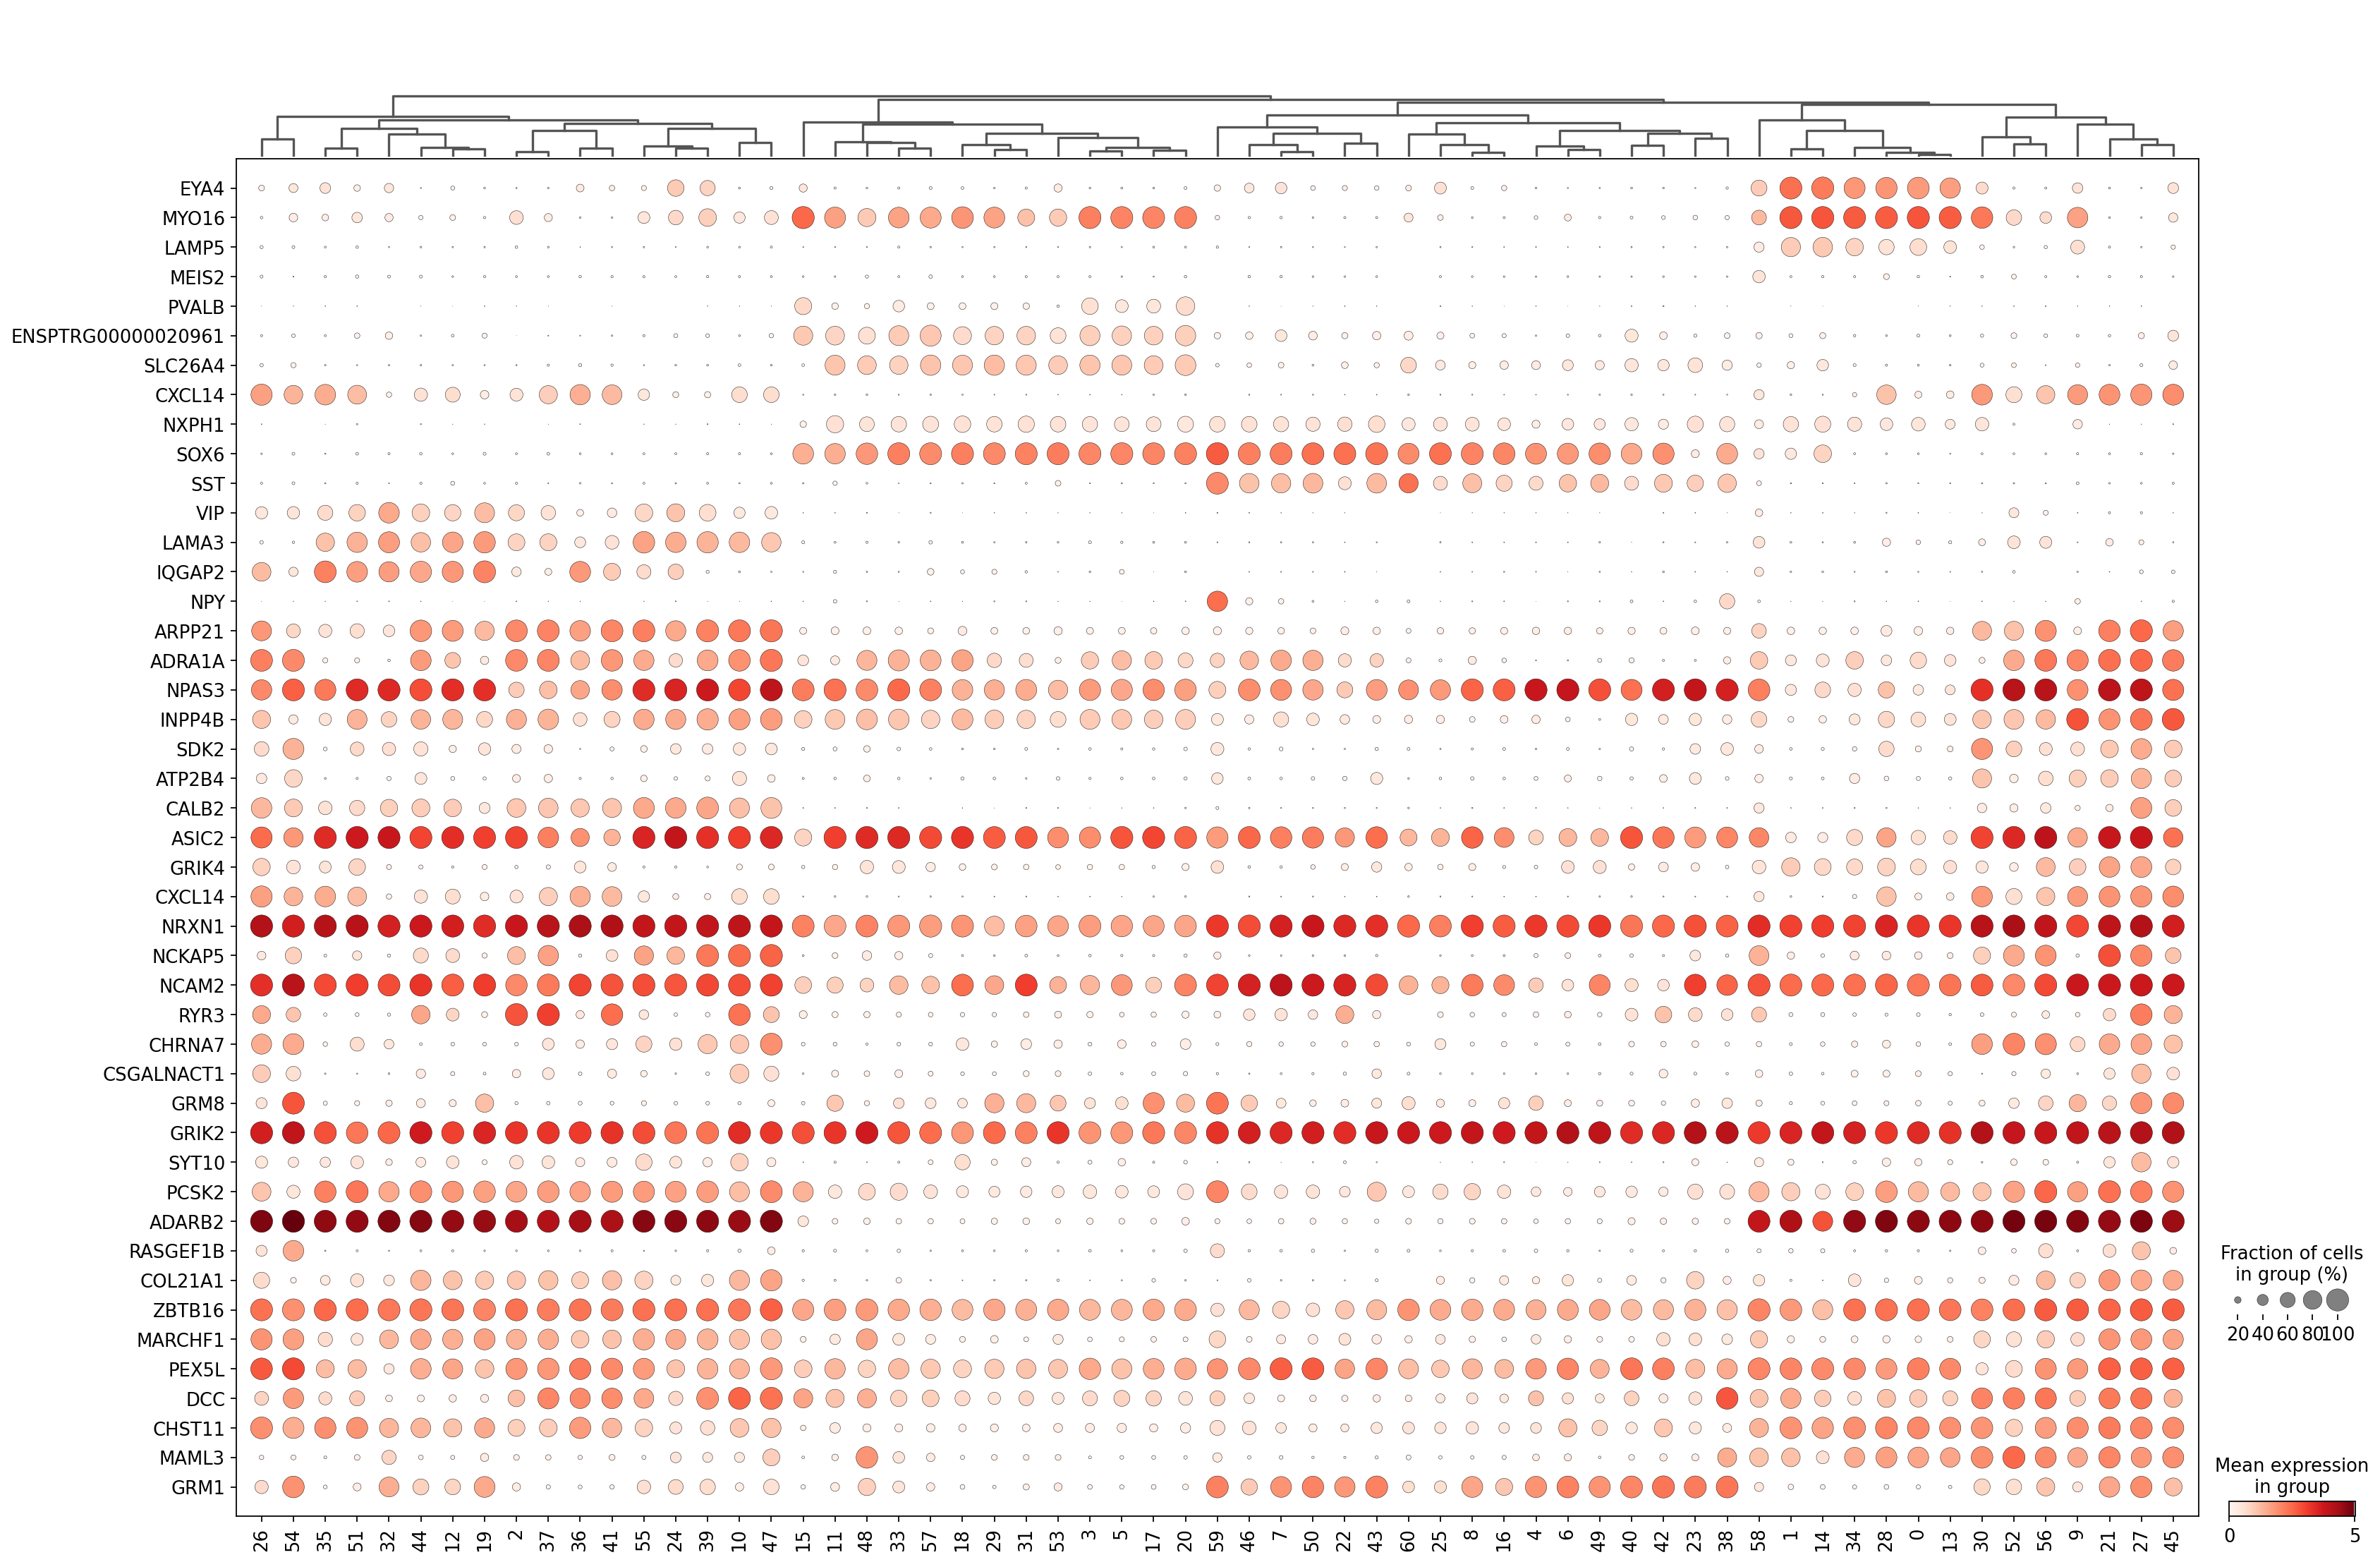

In [ ]:
sc.pl.dotplot(adata, var_names=marker_genes, groupby="leiden", dendrogram=True, swap_axes=True)

In [ ]:
adata.obs['cluster_label'] = np.empty([adata.n_obs], dtype=str)
#del adata.obs['subclass']
#adata.obs['subclass'] = np.empty([adata.n_obs], dtype=str)
pvalb_list = pvalb_1 + pvalb_2 + pvalb_3 + pvalb_4 + pvalb_5 + pvalb_6 + pvalb_7  + pvalb_9 + pvalb_10 + pvalb_11 + pvalb_12 + pvalb_13
print(len(pvalb_list))
for idx,i in enumerate(pvalb_list):
  adata.obs.loc[adata.obs.leiden == i, 'cluster_label'] = 'PVALB_'+str(idx)
  #adata.obs.loc[adata.obs.leiden == i, 'subclass'] = 'Pvalb'
adata.obs.loc[adata.obs.leiden ==  sst_6[0], 'cluster_label'] = 'SST_6'
#adata.obs.loc[adata.obs.leiden ==  sst_6[0], 'subclass'] = 'Pvalb'
adata.obs.loc[adata.obs.leiden ==  sst_6[1], 'cluster_label'] = 'SST_6'
#adata.obs.loc[adata.obs.leiden ==  sst_6[1], 'subclass'] = 'Pvalb'

lamp5_list = lamp5_1 + lamp5_2 + lamp5_3 + lamp5_4 + lamp5_5 + lamp5_6
print(len(lamp5_list))
for idx,i in enumerate(lamp5_list):
  adata.obs.loc[adata.obs.leiden == i, 'cluster_label'] = 'LAMP5_'+str(idx)
  #adata.obs.loc[adata.obs.leiden == i, 'subclass'] = 'Lamp5'
sst_list = sst_1 + sst_2 + sst_3 + sst_4 + sst_5 + sst_6 + sst_7 + sst_8 + sst_9 + sst_10 + sst_11 + sst_12 + sst_13 + sst_14 + sst_15
print(len(sst_list))
for idx,i in enumerate(sst_list):
  adata.obs.loc[adata.obs.leiden == i, 'cluster_label'] = 'SST_'+str(idx)
  #adata.obs.loc[adata.obs.leiden == i, 'subclass'] = 'Sst'
sncg_list = sncg_1 + sncg_2 + sncg_3 + sncg_4 + sncg_5 + sncg_6 + sncg_7
print(len(sncg_list))
for idx,i in enumerate(sncg_list):
  adata.obs.loc[adata.obs.leiden == i, 'cluster_label'] = 'SNCG_'+str(idx)
  #adata.obs.loc[adata.obs.leiden == i, 'subclass'] = 'Sncg'
meis2_list = meis2_lamp5
for idx,i in enumerate(meis2_list):
  adata.obs.loc[adata.obs.leiden == i, 'cluster_label'] = 'MEIS2/LAMP5'
  #adata.obs.loc[adata.obs.leiden == i, 'subclass'] = 'Meis2'
vip_list = vip_1 + vip_2 + vip_3 + vip_4 + vip_5 + vip_6 + vip_7 + vip_8 + vip_9 + vip_10 + vip_11
print(len(vip_list))
for idx,i in enumerate(vip_list):
  adata.obs.loc[adata.obs.leiden == i, 'cluster_label'] = 'VIP_'+str(idx)
  #adata.obs.loc[adata.obs.leiden == i, 'subclass'] = 'Vip'

adata.obs.loc[adata.obs.leiden == sst_chod[0], 'cluster_label'] = 'SST_CHODL'
#adata.obs.loc[adata.obs.leiden == sst_chod[0], 'subclass'] = 'Sst_Chodl'
sncg_vap_list = sncg_vip_pval_1 + sncg_vip_pval_2 + sncg_vip_3 + sncg_vip_4 + sncg_vip_1 + sncg_vip_2
for idx,i in enumerate(sncg_vap_list):
  adata.obs.loc[adata.obs.leiden == i, 'cluster_label'] = 'SNCG_VIP_'+str(idx)



In [ ]:
sc.pl.stacked_violin(adata, marker_genes, groupby="leiden");


In [ ]:
adata.write_h5ad(os.path.join(output_data_dir,"Chimp_inh_level2_level3_cluster.h5ad"),compression='gzip')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


/content/drive/MyDrive/virtual_env/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/content/drive/MyDrive/virtual_env/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/content/drive/MyDrive/virtual_env/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


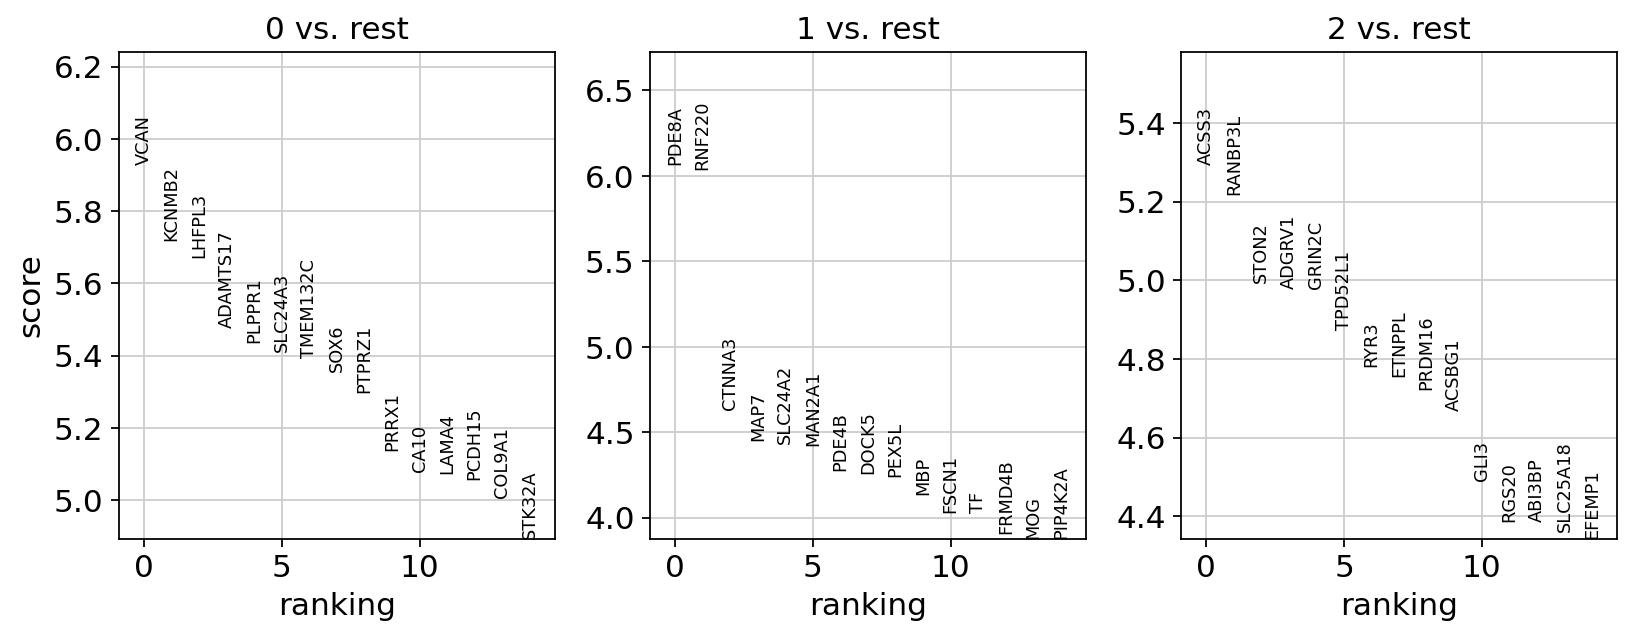

In [ ]:
sc.tl.rank_genes_groups(a11, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(a11, n_genes=15, sharey=False,show=False)